In [108]:
import numpy as np
import pandas as pd
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [109]:
# Constants
r_n1 = 1.0e-6  
r_n2 = 1.0     
r_t1 = 1.0e-6 
r_h1 = 2.2e-17 
r_h2 = 1.1e-4  
K_n = 5.0e7   
K_t = 5.0e7   
D_t = 2.0e-10 
D_h = 5.0e-6   
r_s = 50      
r_21 = 0.0895

# Domain Setup
R = 0.5  
N = 100   
r = np.linspace(0, R, N+1)
h = r[1] - r[0]

T = 5.00256e6  
dt = 11.6    
steps = int(np.ceil(T / dt))  

output_times = np.array([0, 11.6, 23.2, 34.8, 46.4, 57.9]) * 86400  

output_steps = []
for t_out in output_times[1:]: 
    steps_array = np.arange(steps)
    t_array = (steps_array + 1) * dt
    step = np.argmin(np.abs(t_array - t_out))
    output_steps.append(step)
output_steps_set = set(output_steps)  

In [110]:
# Initial conditions

tanh_r = np.tanh(r_s * (r - r_21))
Nn = 5.0e7 * (1 - tanh_r) / 2 + 1.0e8 * (1 + tanh_r) / 2
Nt = 1.0e5 * (1 - tanh_r) / 2 + 1.0e3 * (1 + tanh_r) / 2
Ch = 1.0e-9 * (1 - tanh_r) / 2

In [111]:
# Stiffness Matrix

def stiffness_matrix(w):
    w_avg = (w[:-1] + w[1:]) / 2
    diag = np.zeros(N + 1)
    diag[0] = w_avg[0] / h
    diag[1:-1] = (w_avg[:-1] + w_avg[1:]) / h
    diag[-1] = w_avg[-1] / h
    off_diag = -w_avg / h
    return diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

In [ ]:
# Mass Matrix M

diag = np.zeros(N + 1)
off_diag = np.zeros(N)

for i in range(1, N):
    r_m_left = (r[i - 1] + r[i]) / 2
    r_m_right = (r[i] + r[i + 1]) / 2
    diag[i] = (h / 3) * (r_m_left**2 + r_m_right**2)

diag[0] = (h / 3) * ((r[0] + r[1]) / 2)**2
diag[N] = (h / 3) * ((r[N - 1] + r[N]) / 2)**2

for i in range(N):
    r_m = (r[i] + r[i + 1]) / 2
    off_diag[i] = (h / 6) * r_m**2
M_r2 = diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

data = []

for i, ri in enumerate(r):
    pH = -np.log10(np.clip(Ch[i], 1e-20, None))
    data.append([0.0, ri, Nn[i], Nt[i], Ch[i], np.clip(pH, 1.4, 7.6)])

# Main Program
for step in range(steps):
    t = (step + 1) * dt

    Nn_curr = Nn.copy()
    Nt_curr = Nt.copy()
    Ch_curr = Ch.copy()

    f_Nn = r_n1 * Nn_curr * (1 - Nn_curr / K_n) - r_n2 * Ch_curr * Nn_curr
    f_Nt = r_t1 * Nt_curr * (1 - Nt_curr / K_t)
    f_Ch = r_h1 * Nt_curr - r_h2 * Ch_curr

    D_Nn = D_t * (1 - Nn_curr / K_n)
    w_Nt = D_Nn * r**2
    K_Nt = stiffness_matrix(w_Nt)
    A_Nt = M_r2 + dt * K_Nt
    b_Nt = M_r2 @ Nt_curr + dt * M_r2 @ f_Nt
    Nt = spsolve(csc_matrix(A_Nt), b_Nt)

    w_Ch = D_h * r**2
    K_Ch = stiffness_matrix(w_Ch)
    A_Ch = M_r2 + dt * K_Ch
    b_Ch = M_r2 @ Ch_curr + dt * M_r2 @ f_Ch
    Ch = spsolve(csc_matrix(A_Ch), b_Ch)

    Nn = Nn_curr + dt * f_Nn

    Nn = np.clip(Nn, 0, 1.1 * K_n)
    Nt = np.clip(Nt, 0, 1.1 * K_t)
    Ch = np.clip(Ch, 0, 1e-6)

    if step in output_steps_set:
        for i, ri in enumerate(r):
            pH = -np.log10(np.clip(Ch[i], 1e-20, None))
            data.append([t, ri, Nn[i], Nt[i], Ch[i], np.clip(pH, 1.4, 7.6)])

df = pd.DataFrame(data, columns=['t', 'r', 'N_n', 'N_t', 'C_h', 'pH'])
df.to_csv('FEM.csv', index=False)

,t,r,N_n,N_t,C_h,pH
0,0.000000,0.000,5.000649e+07,99987.157687,9.998703e-10,7.600000
1,0.000000,0.005,5.001069e+07,99978.828387,9.997861e-10,7.600000
2,0.000000,0.010,5.001763e+07,99965.098754,9.996475e-10,7.600000
3,0.000000,0.015,5.002906e+07,99942.470730,9.994189e-10,7.600000
4,0.000000,0.020,5.004789e+07,99905.186012,9.990423e-10,7.600000
...,...,...,...,...,...,...
601,57.899977,0.480,4.904648e+07,148350.482601,3.901755e-08,7.408740
602,57.899977,0.485,4.904698e+07,148350.482606,3.899830e-08,7.408954
603,57.899977,0.490,4.904734e+07,148350.482601,3.898470e-08,7.409106
604,57.899977,0.495,4.904755e+07,148350.482606,3.897663e-08,7.409196


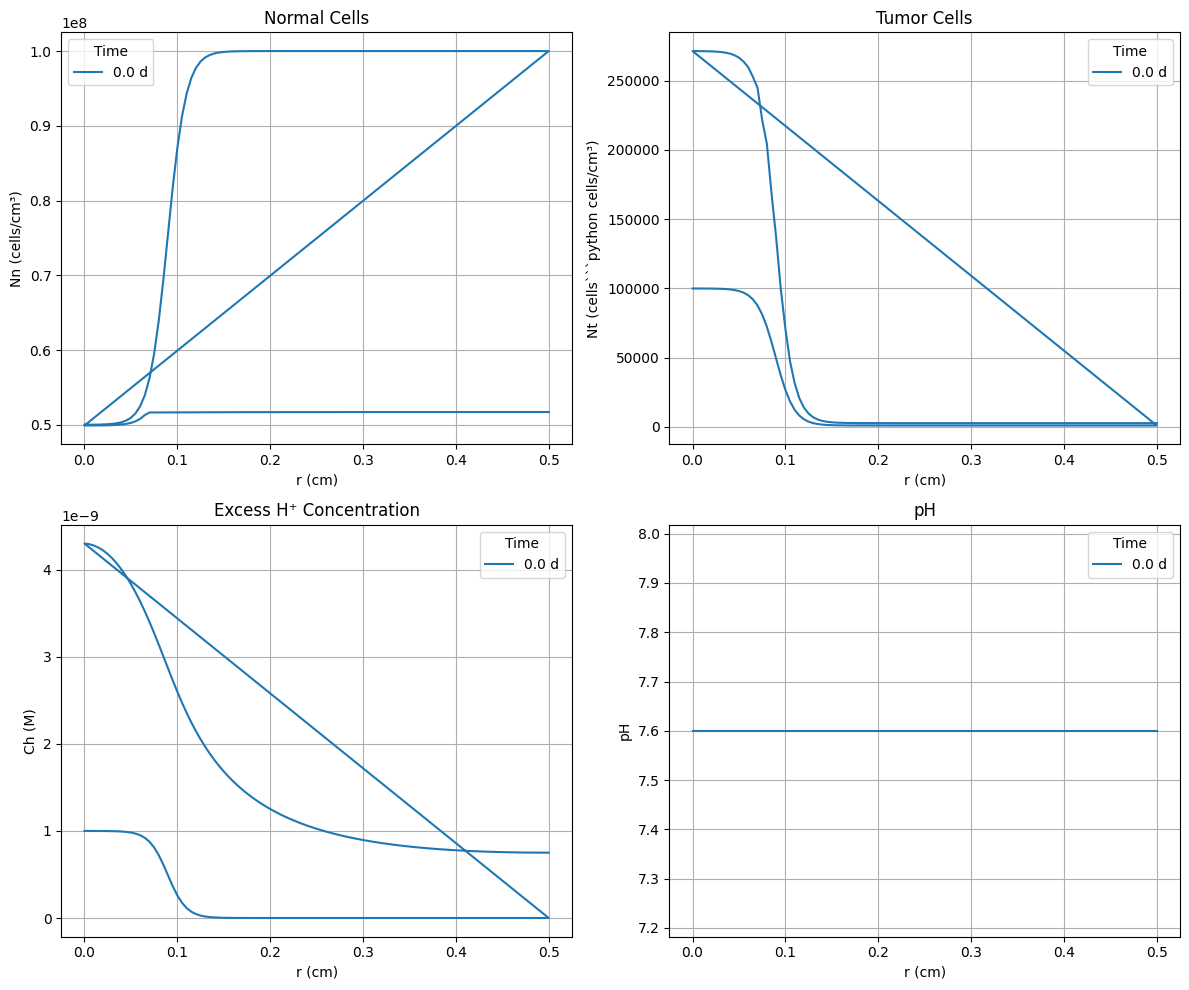

In [ ]:
# Display Output
display(df)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_n'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nn (cells/cm³)')
plt.title('Normal Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 2)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_t'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nt (cells```python cells/cm³)')
plt.title('Tumor Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 3)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['C_h'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Ch (M)')
plt.title('Excess H⁺ Concentration')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 4)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['pH'], label=f'{t / (3600*24):.1f} d')
        
plt.xlabel('r (cm)')
plt.ylabel('pH')
plt.title('pH')
plt.legend(title='Time')
plt.grid(True)

plt.tight_layout()
plt.show()